- n x n マス空間に幅１マスの道があり、それ以外のマスは落とし穴。
- 道は右下に向かって伸びている。
- ゴールはnマス先にある。
- エージェントはスタート地点から①下に移動　②右に移動　のどちらかを選んで行動する。
- ゴールすると+1の報酬が得られる。途中で落とし穴に落ちるとスタート地点からやり直し。

In [1]:
from blindcliftwalk import BlindCliftwalk

# ゴールまでの距離
nb_step = 20

# ゴールの数
nb_goals = 3

env = BlindCliftwalk(nb_step, nb_goals)

In [2]:
import numpy as np

np.random.seed(seed=50)
env.set_ground_truth()
env.ground_truth

array([[2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

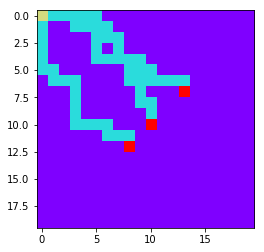

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(env.ground_truth, 'rainbow', interpolation='nearest')
#plt.savefig('ground_truth.png')

# value functionをEvery-Visit MC法で学習する

In [4]:
# モンテカルロサンプリングの数
mc_step = 300000

# 最大更新回数
max_update = 100

# 割引率
gamma = 1. - 1. / float(nb_step)

# 学習率
learning_rate = 0.25

# 考えうる状態の数はground_truthの大きさと同じ（もう少し小さいが、面倒なので同じとする）
value_table = np.zeros_like(env.ground_truth, dtype=float)

#save_interval = 10000
save_interval = 1000

# ε-greedyのハイパーパラメータ
epsilon = 0.3

In [5]:
from tqdm import tqdm

stacked_value_table = []
isSuccessed = False

value_table = np.zeros_like(value_table) # state valueの初期化（念のためループ直前でも初期化する）
try:
    count = 0
    for i in tqdm(range(mc_step)):
        # 状態の初期化
        current_state = np.zeros(2, dtype=int)

        status = 0
        stacked_states = []
        stacked_rewards = []
        while status >= 0:
            # state valueが最大となる行動を取る（まだ遷移させない）。
            if np.random.random(1) > epsilon:
                action_candidates = [[0,1], [1,0]]
                next_state_1, _, _ = env.do_action(current_state, action_candidates[0])
                next_state_2, _, _ = env.do_action(current_state, action_candidates[1])
                v1 = value_table[next_state_1[0], next_state_1[1]]
                v2 = value_table[next_state_2[0], next_state_2[1]]
                v_candidates = np.array([v1,v2])
                action = action_candidates[v_candidates.argmax()]
            else:
                action = env.random_action()

            # 状態の遷移（マス目の移動）
#            state = env.transition(state, action)

            # 行動に対する報酬と遷移後の状態の計算
            next_state, reward, status = env.do_action(current_state, action)

            # 現在の状態と得られた報酬の保存（エピソード終了後に破棄）
            stacked_states.append(current_state)
            stacked_rewards.append(reward)
        
            # 状態の遷移（マス目の移動）
            current_state = next_state        

            if status==1:
                '''
                ゴールまでたどり着いたら道中のstate valueを更新する。
                '''
                isSuccessed = True
                R = 0
                for s,r in zip(reversed(stacked_states), reversed(stacked_rewards)):
                    # ゴールから遠いstateには割引されたrewardを与える。
                    R = r + gamma * R

                    # state valueを更新する。
                    V = value_table[s[0], s[1]]
                    value_table[s[0], s[1]] = V + learning_rate * (R - V)

                # state valueが更新されるたびにその値を保存しておく（学習過程の可視化のため）。
                # なお、np.copy()を使わないとリスト中のすべてのvalue_tableが同じ値になってしまう。
#                stacked_value_table.append(np.copy(value_table))
                
            if isSuccessed:
#            if True:
                count += 1
                if count==save_interval:
                    stacked_value_table.append(np.copy(value_table))
                    count = 0
                
        if len(stacked_value_table)==max_update:
            raise Exception
            
except Exception:
    pass

 29%|██▉       | 87710/300000 [00:08<00:21, 9944.51it/s] 


# 学習過程の可視化
- Every-Visit MC法ではゴールまでたどり着くたびにvalue functionが更新される。その過程を見る。

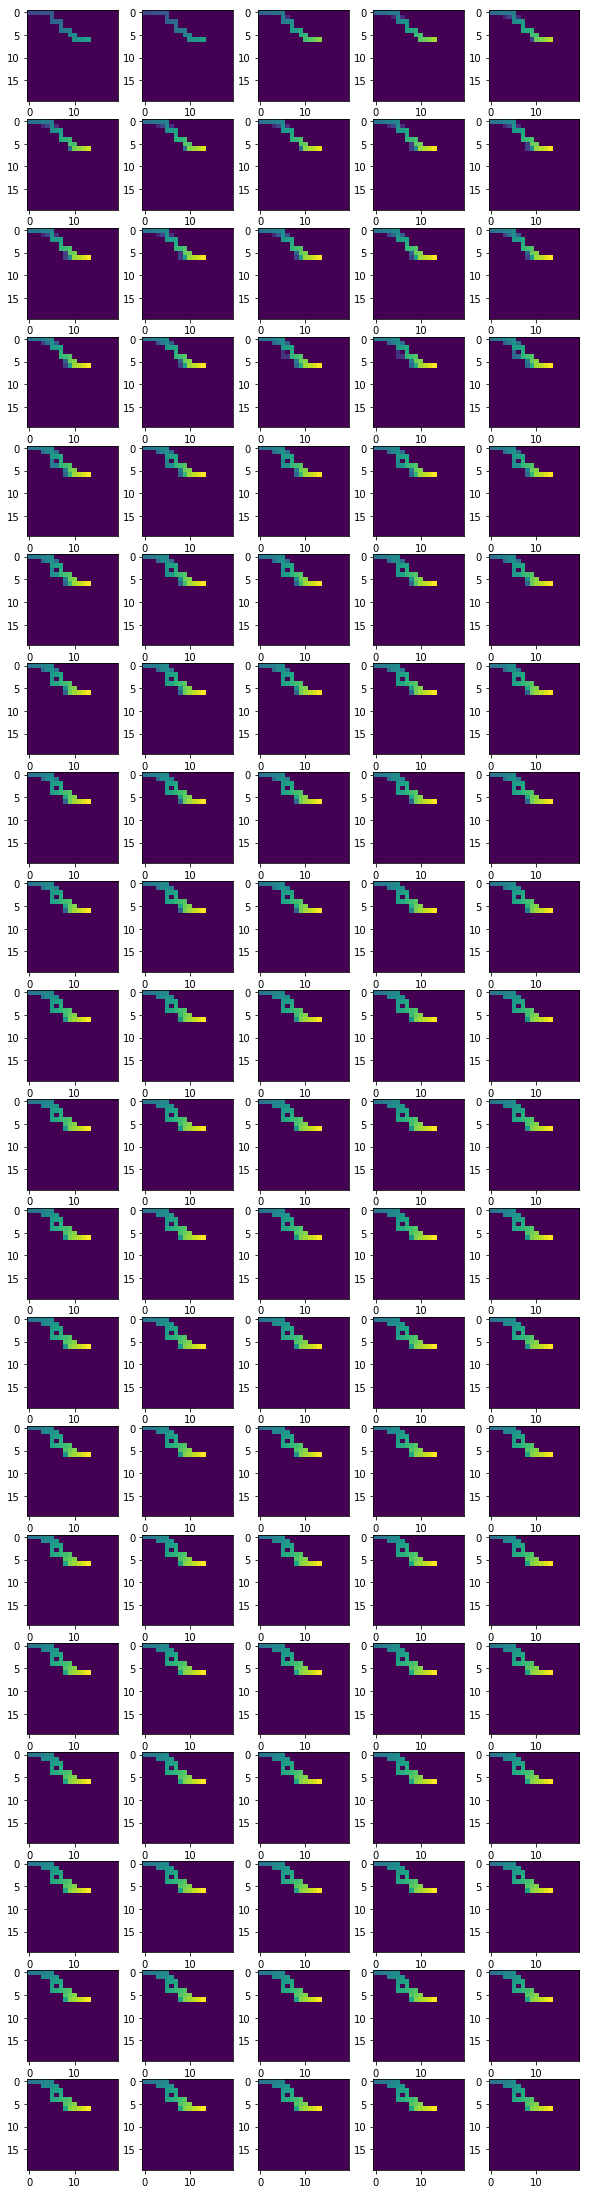

In [6]:
if isSuccessed:
    nb = 0
    plt.figure(figsize=(10,10*int(len(stacked_value_table)+1)/5.))
    for v in stacked_value_table:
        nb += 1
        plt.subplot(int(len(stacked_value_table)+1),5,nb)
        plt.imshow(v, interpolation='nearest')
        plt.clim(0,1)

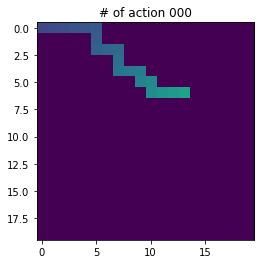

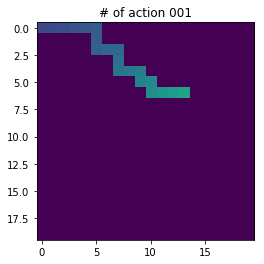

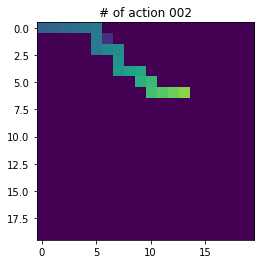

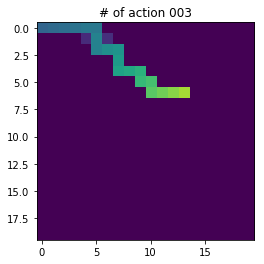

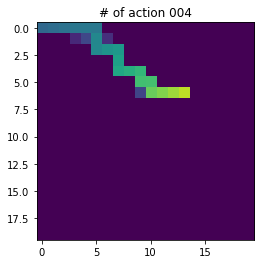

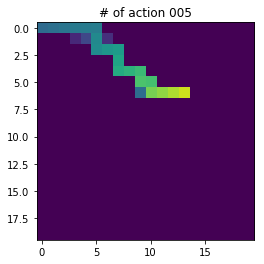

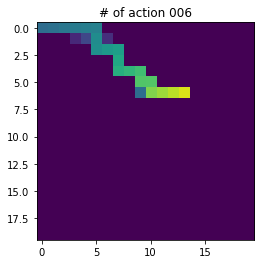

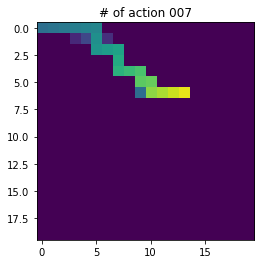

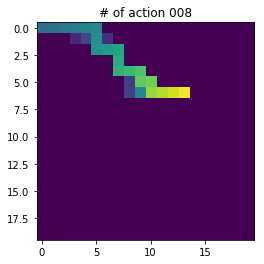

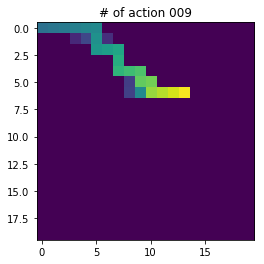

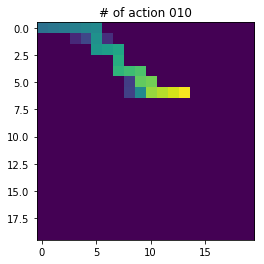

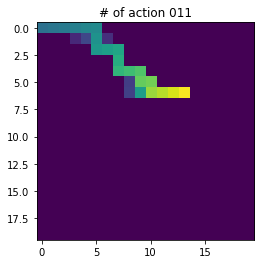

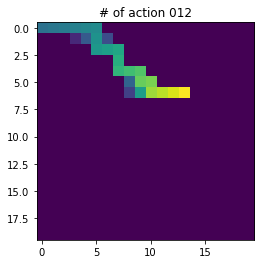

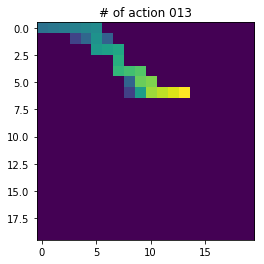

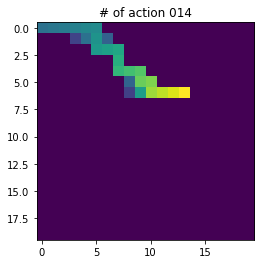

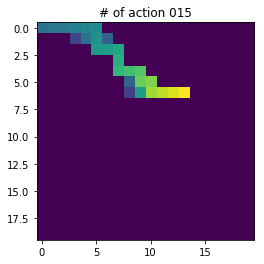

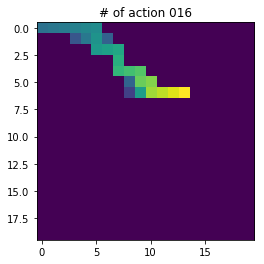

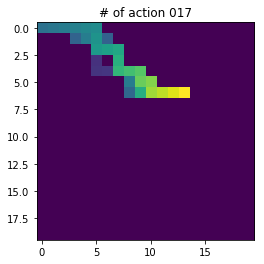

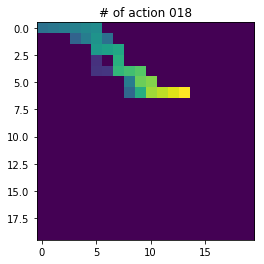

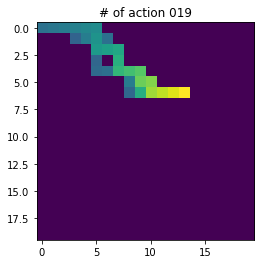

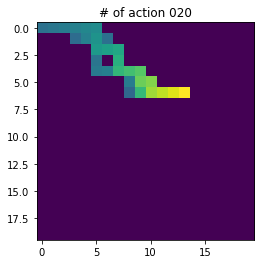

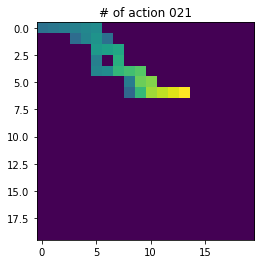

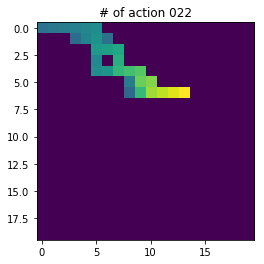

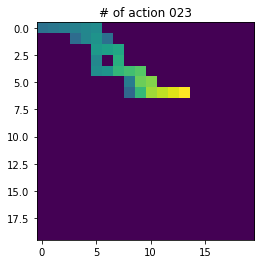

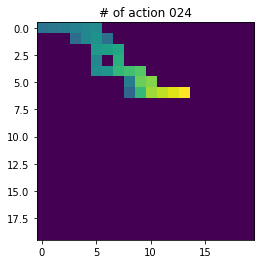

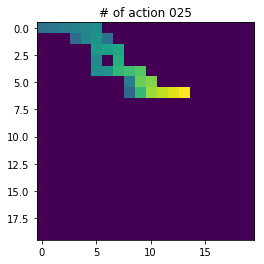

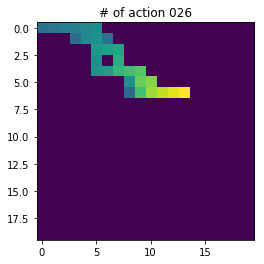

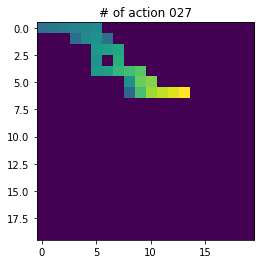

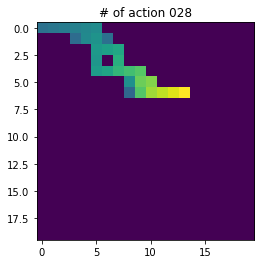

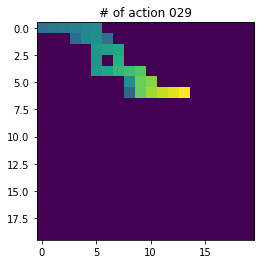

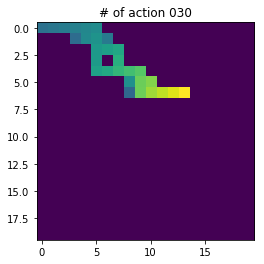

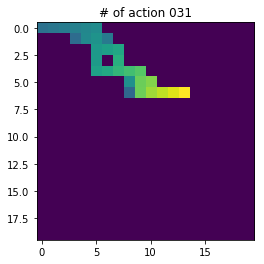

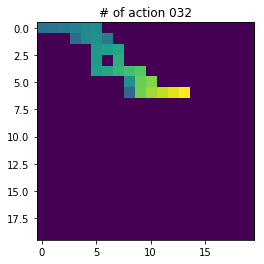

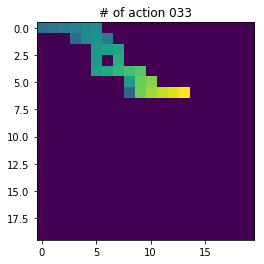

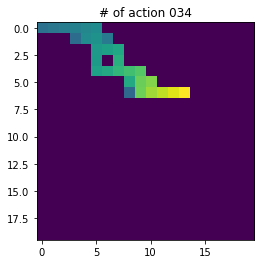

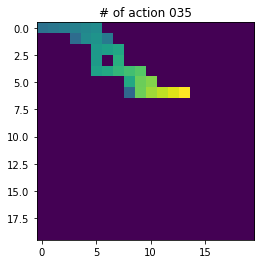

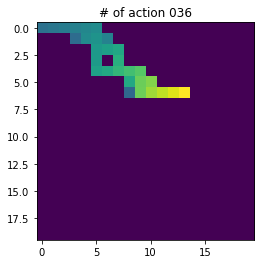

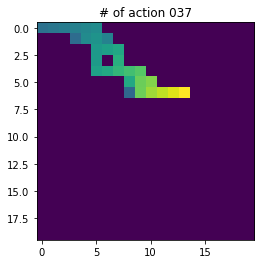

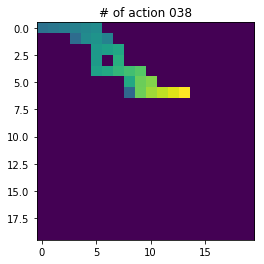

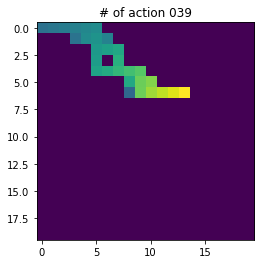

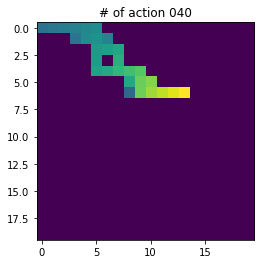

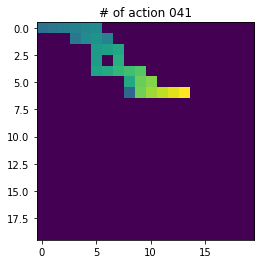

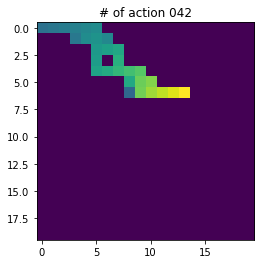

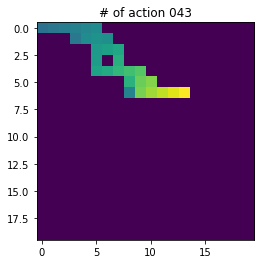

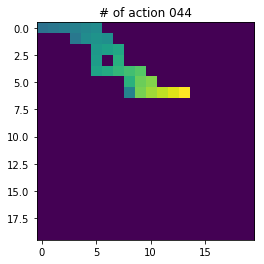

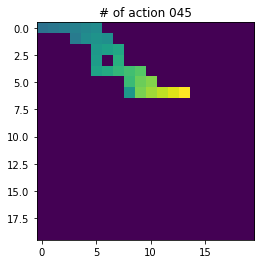

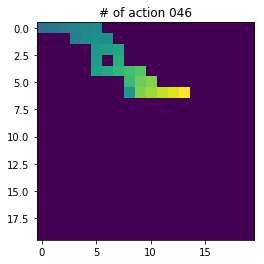

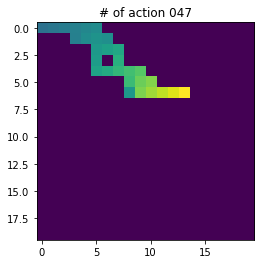

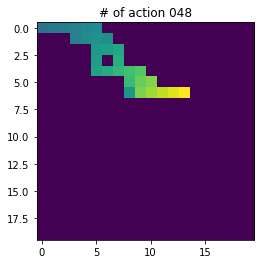

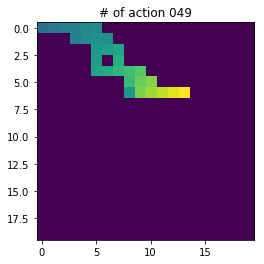

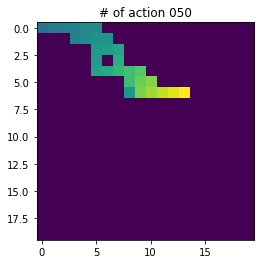

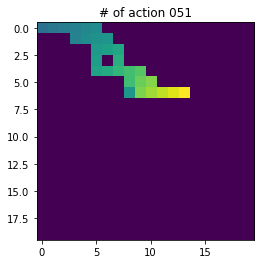

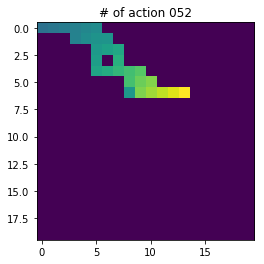

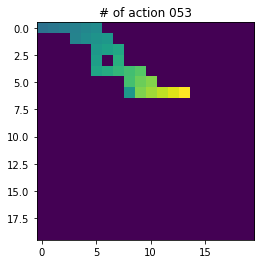

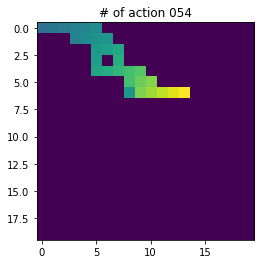

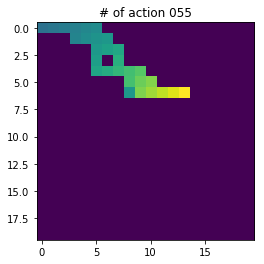

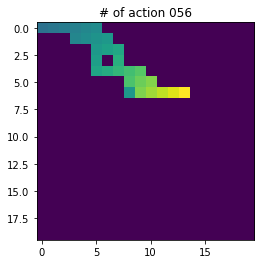

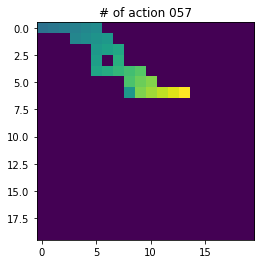

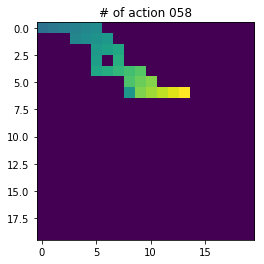

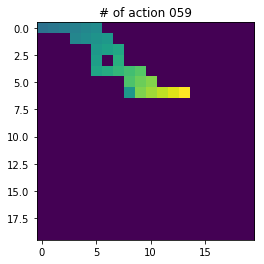

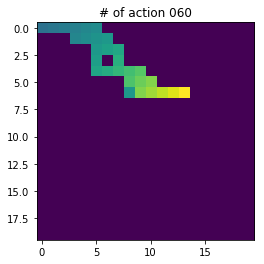

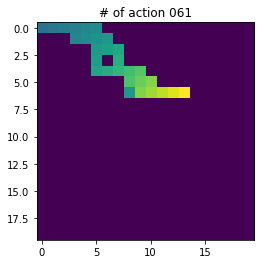

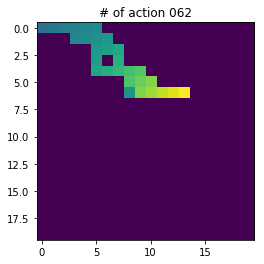

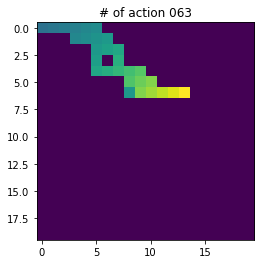

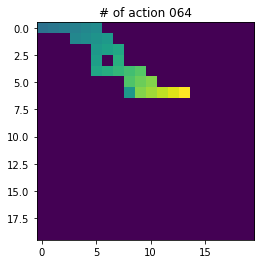

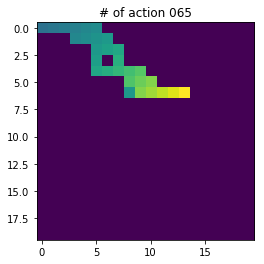

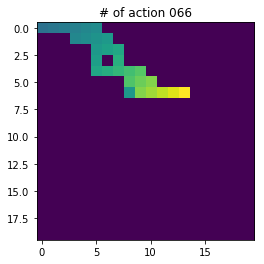

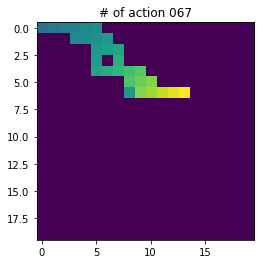

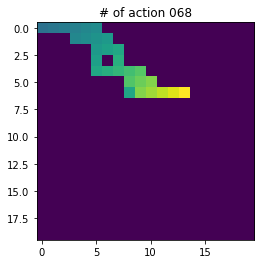

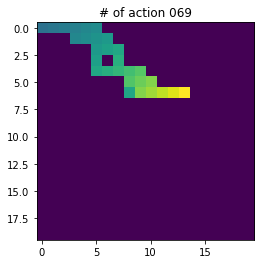

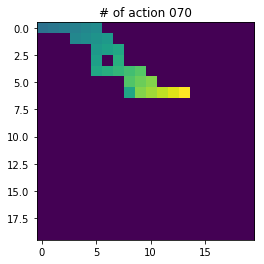

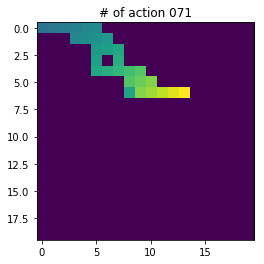

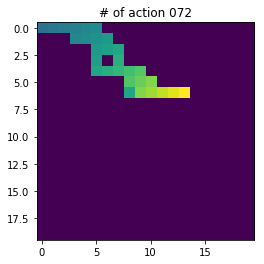

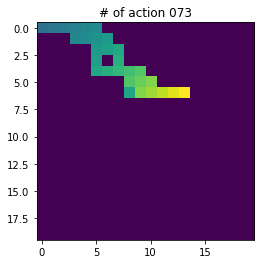

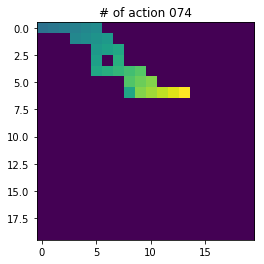

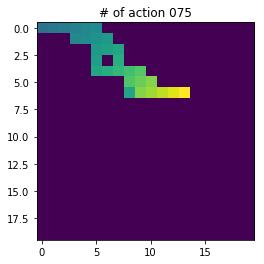

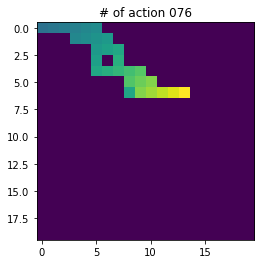

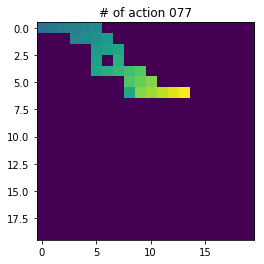

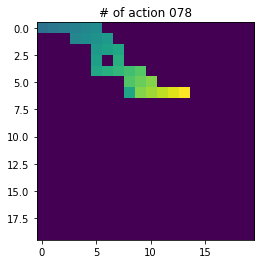

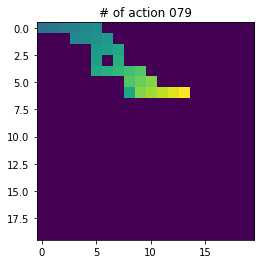

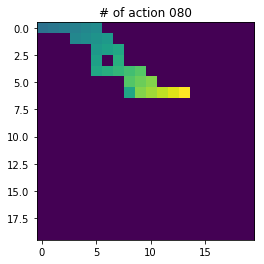

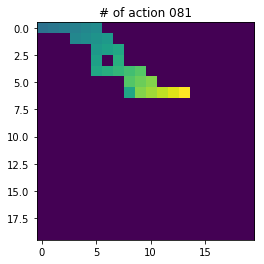

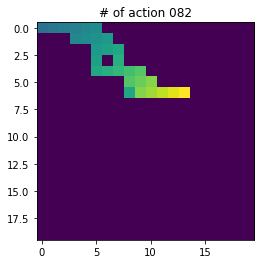

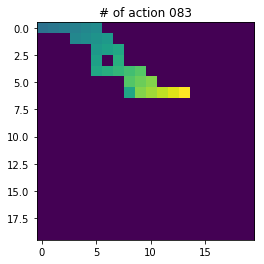

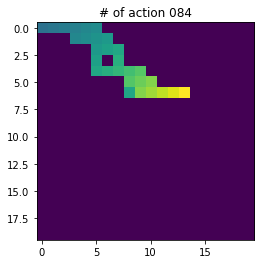

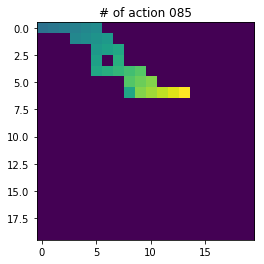

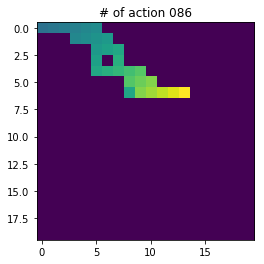

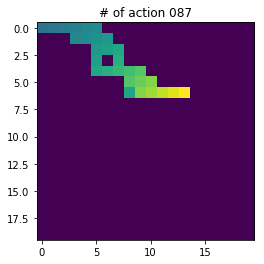

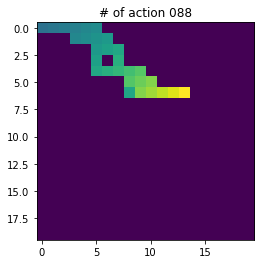

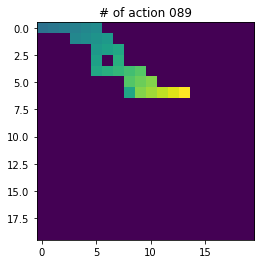

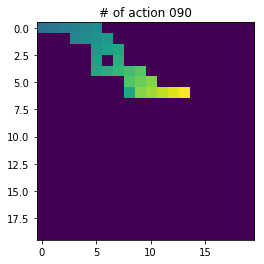

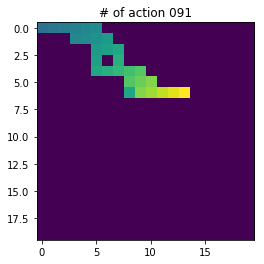

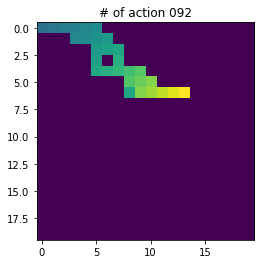

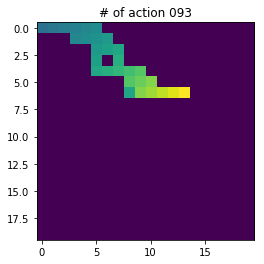

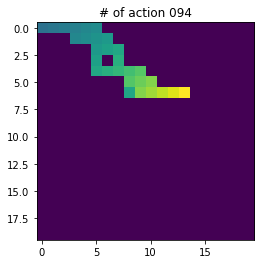

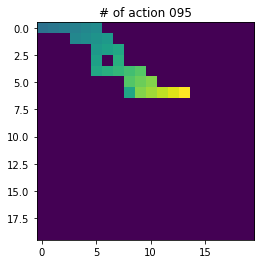

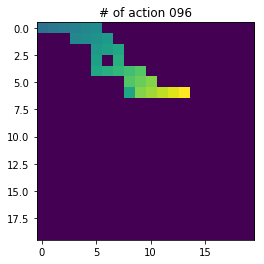

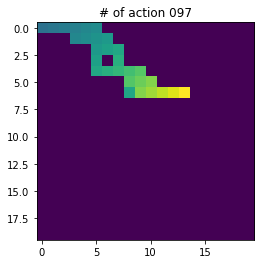

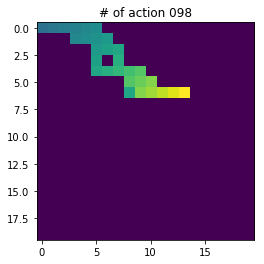

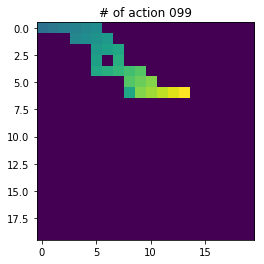

In [7]:
for i,v in enumerate(stacked_value_table[:200]):
    plt.imshow(v, interpolation='nearest')
    plt.clim(0,1)
    plt.title('# of action '+str(i).zfill(3))
    plt.savefig('EVMC_iter_'+str(i).zfill(3)+'.png')
    plt.show()